# The Variational EM algorithm of LDA

In [112]:
import utilities
import numpy as np
import re
import string
import collections
import random
from scipy.special import gammaln, psi, polygamma
from functools import reduce
from warnings import warn
import random
import sys
import matplotlib.pyplot as plt


In [113]:
# an example of parsing a document
doc='two-three one, Sth*, five, else ^#%$@#@#'
vocab=dict(zip(('one','two','three','sth','four','else'),range(6)))
parsed_doc=utilities.parse_doc(doc,vocab)
parsed_doc


[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1)]

## The equivalent class of words
Suppose we have a single document. Let 

$$\tilde{w_n}=\text{j such that }w_n^j=1$$
To carry out the inference, first note that for fixed $i,j$, $\{\phi_{ni}: \tilde{w_n}=j\}$ will all be the same. This suggests us to define the following quantity:

$$\tilde{\phi_{ji}}=\phi_{ni}, \text{ where }\tilde{w_n}=j$$
We only need to update $\tilde{\phi}$ in the variational inference (E-step). For fixed $i$, the length of $\tilde{\phi}_{:,i}$ is the cardinality of $\{\tilde{w_n}: n=1,\cdots, N\}$.


In [114]:
def variational_inference(N,k,V,alpha,beta,w,conv_threshold=1e-5,max_iter=int(1e6)):
    """
    Variational inference algorithm for document-specific parameters of a single doc in LDA (figure 6 in the paper)
    Arguments:
    N: number of words in the document
    k: number of topics
    V: length of vocabulary
    alpha: corpus-level Dirichlet parameter, k-vector
    beta: corpus-level multinomial parameter, k * V matrix
    w: word id obtained from parsing the document
    conv_threshold: threshold for convergence
    max_iter: maximum number of iterations
    Output:
    A tuple of document specific optimizing parameters $(\gamma^*, \phi^*)$ obtained from variational inference.  
    First element: $\gamma^*$, k-vector
    Second element: the second sum in Eq(9), k*V matrix
    """
    phi0=np.full(shape=(N,k),fill_value=1/k) 
    phi1=phi0
    gamma0=alpha+N/k
    for it in range(max_iter):
        for n in range(N):
            for i in range(k):
                phi1[n,i]=beta[i,w[n]]*np.exp(psi(gamma0[i]))
            phi1[n,]=phi1[n,]/np.sum(phi1[n,])
        gamma1=alpha+np.sum(phi1,axis=0)
        # stop if gamma has converged
        if np.mean(np.abs(gamma0-gamma1))<conv_threshold:
            break
        gamma0=gamma1
        phi0=phi1 
    suff_stat=np.zeros(shape=(V,k))
    for n in range(N):
        suff_stat[w[n],]=suff_stat[w[n],]+phi1[n,]
    return (gamma1,suff_stat.T) 

In [115]:
def e_step(N,k,V,alpha,beta,word_dict,conv_threshold=1e-5,max_iter=int(1e6)):
    """
    Variational inference algorithm for document-specific parameters of a single doc in LDA with the equivalent class representation.
    Arguments:
    N: number of words
    k: number of topics
    V: length of vocabulary
    alpha: corpus-level Dirichlet parameter, k-vector
    beta: corpus-level multinomial parameter, k * V matrix
    word_dict: word_dict from parse_doc
    conv_threshold: threshold for convergence
    max_iter: maximum number of iterations
    Output:
    A tuple of document specific optimizing parameters $(\gamma^*, \phi^*)$ obtained from variational inference.  
    First element: $\gamma^*$, k-vector
    Second element: the second sum in Eq(9), k*V matrix
    """
    conv=False
    wordid=list(map(lambda x:x[0],word_dict))
    wordcnt=list(map(lambda x:x[1],word_dict))
    phi0=np.full(shape=(len(wordid),k),fill_value=1/k) # phi_tilde 
    phi1=np.zeros(shape=(len(wordid),k))
    gamma0=alpha+N/k
    for it in range(max_iter):
        for j in range(len(wordid)):
            # the jth row of phi1 corresponds to the word labelled as wordid[j]
            for i in range(k):
                #phi1[j,i]=beta[i,wordid[j]]*np.exp(psi(gamma0[i]))*wordcnt[j]
                phi1[j,i]=beta[i,wordid[j]]*np.exp(psi(gamma0[i]))
            phi1[j,]=phi1[j,]/np.sum(phi1[j,])
        gamma1=alpha+np.sum(phi1*(np.array(wordcnt).reshape((-1,1))),axis=0)
        #gamma1=alpha+np.sum(phi1,axis=0)
        # stop if gamma has converged
        if np.max(np.abs((gamma0-gamma1)))<conv_threshold:
            conv=True
            break
        gamma0=gamma1
        phi0=phi1 
    if not conv:
        warn('Variational inference has not converged. Try more iterations.')
    suff_stat=np.zeros(shape=(V,k))
    suff_stat[wordid,]=phi1*(np.array(wordcnt).reshape((-1,1)))
    #print(suff_stat)
    #print('gamma1:',gamma1)
    return (gamma1,suff_stat.T) 

## The M-step

The parameters $\beta$ and $\alpha$ are updated in the M step. 

$\beta$ is updated with Eq(9). 

$\alpha$ is updated with Newton-Raphson:
$$\alpha_{new}=\alpha_{old}-H(\alpha_{old})^{-1}g(\alpha_{old}),$$
where $H(\alpha)=(\frac{\partial^2\mathcal{L}}{\partial\alpha_i\partial\alpha_j})_{k\times k}$ is the Hessian matrix and $g(\alpha)=(\frac{\partial \mathcal{L}}{\partial \alpha_i})_{i=1}^k$ is the gradient. 

A.4.2 shows that 
$$\frac{\partial \mathcal{L}}{\partial \alpha_i}=M \left(\Psi\left(\sum_{j=1}^k \alpha_j\right)-\Psi(\alpha_i)\right) + \sum_{d=1}^M \left(\Psi(\gamma_{di})-\Psi(\sum_{j=1}^k\gamma_{dj}) \right),$$
$$\frac{\partial^2\mathcal{L}}{\partial\alpha_i\partial\alpha_j}=\delta(i,j)M\Psi'(\alpha_i)-\Psi'\left(\sum_{j=1}^k\alpha_j\right),$$
i.e.,
$$H(\alpha)=diag(h)+1z1^T,$$
where $$z=-\Psi'\left(\sum_{j=1}^k\alpha_j\right),h=M\Psi'(\alpha)$$
By A.2, we have 
$$(H^{-1}g)_i=\frac{g_i-c}{h_i},$$
where 
$$c=\frac{\sum_{j=1}^k g_j/h_j}{1/z+\sum_{j=1}^k h_j^{-1}}$$

In [116]:
def m_step(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-5,max_iter=int(1e6)):
    """
    M-step in variational EM, maximizing the lower bound on log-likelihood w.r.t. alpha and beta. (Section 5.3)
    Arguments:
    M: number of documents in the corpus
    k: number of topics
    V: length of vocab
    suff_stat_list: M-list of sufficient statistics (k * V matrices), one for each doc
    gamma_list: M-list of gamma's (k-vectors), one for each doc
    alpha0: initialization of alpha in Newton-Raphson
    conv_threshold: convergence threshold in Newton-Raphson
    max_iter: maximum number of iterations in Newton-Raphson
    Output:
    A 2-tuple. 
    First element: beta (k*V matrix)
    Second element: alpha (k*1)
    """
    alphalist=[alpha0]
    ll=[]
    ll0=conv_threshold
    conv=False
    # update beta
    beta=reduce(lambda x,y: x+y, suff_stat_list)
    beta=beta/np.sum(beta,axis=1).reshape((-1,1))
    # update alpha (Newton-Raphson)
    alpha0=alpha0.reshape(k,1)
    psi_sum_gamma=np.array(list(map(lambda x: psi(np.sum(x)),gamma_list))).reshape((M,1)) # M*1 
    psi_gamma=psi(np.array(gamma_list)) # M*k matrix
    #print('gamma',psi_sum_gamma,psi_gamma)
    for it in range(max_iter):
        psi_sum_alpha=psi(np.sum(alpha0))
        #print('psi_sum_alpha',psi_sum_alpha)
        g=M*(psi_sum_alpha-psi(alpha0)).reshape((k,1))+np.sum(psi_gamma-psi_sum_gamma,axis=0).reshape((k,1)) # k*1 
        #print('g',g)
        #h=M*polygamma(1,alpha0) # k*1
        h=-M*polygamma(1,alpha0) # k*1
        #print('h',h)
        #z=-polygamma(1,np.sum(alpha0))
        #z=polygamma(1,np.sum(alpha0))
        z=polygamma(1,np.sum(alpha0))*M
        c=np.sum(g/h.reshape((k,1)))/(1/z+np.sum(1/h))
        #print('c',c)
        invHg=(g-c)/h.reshape((k,1))
        #print('invHg:')
        #print(invHg)
        #print('g:')
        #print(g)
        alpha1=alpha0-invHg 
        #############
        #alpha1=np.abs(alpha1)
        #############
        #alpha1=np.clip(alpha1,1e-10,1e100) # for numerical stability
        ll1=utilities.loglik(alpha1,gamma_list,M,k)
        ll.append(ll1)
        if np.abs((ll1-ll0)/ll0)<conv_threshold:
            print('newton finished at iteration',it)
            conv=True
            break
        print('alpha1:')
        print(alpha1)
        #print('loglik:')
        #print(utilities.loglik(alpha1,gamma_list,M,k))
        alpha0=alpha1
        alphalist.append(alpha1)
        ll0=ll1
    if not conv:
        warn('Newton-Raphson has not converged. Try more iterations.')
    return (beta,alpha1,ll,alphalist)

In [117]:
def m_step_gd(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-5,max_iter=int(1e6),stepsize=0.05):
    alphalist=[alpha0]
    ll=[]
    ll0=conv_threshold
    conv=False
    # update beta
    beta=reduce(lambda x,y: x+y, suff_stat_list)
    beta=beta/np.sum(beta,axis=1).reshape((-1,1))
    # update alpha (Newton-Raphson)
    alpha0=alpha0.reshape(k,1)
    psi_sum_gamma=np.array(list(map(lambda x: psi(np.sum(x)),gamma_list))).reshape((M,1)) # M*1 
    psi_gamma=psi(np.array(gamma_list)) # M*k matrix
    #print('gamma',psi_sum_gamma,psi_gamma)
    for it in range(max_iter):
        psi_sum_alpha=psi(np.sum(alpha0))
        #print('psi_sum_alpha',psi_sum_alpha)
        g=M*(psi_sum_alpha-psi(alpha0)).reshape((k,1))+np.sum(psi_gamma-psi_sum_gamma,axis=0).reshape((k,1)) # k*1 
        #print('g:')
        #print(g)
        alpha1=alpha0+stepsize*g #because we are looking for MAXIMUM
        #############
        #alpha1=np.abs(alpha1)
        #############
        #alpha1=np.clip(alpha1,1e-10,1e100) # for numerical stability
        ll1=utilities.loglik(alpha1,gamma_list,M,k)
        ll.append(ll1)
        if np.abs((ll1-ll0)/ll0)<conv_threshold:
            print('GD finished at iteration',it)
            conv=True
            break
        #print('alpha1:')
        #print(alpha1)
        #print('loglik:')
        #print(utilities.loglik(alpha1,gamma_list,M,k))
        alpha0=alpha1
        ll0=ll1
        alphalist.append(alpha1)
    if not conv:
        warn('GD has not converged. Try more iterations.')
    return (beta,alpha1,ll,alphalist)

## The variational EM without smoothing 

In [118]:
def variational_em(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-5,max_iter=int(1e6),niter=int(1e6)):
    """
    Input:
    Nd: list of length of documents 
    alpha0: initialization of alpha
    beta0: initialization of beta. DO NOT initialize with identical rows!
    word_dicts: list of word_dict of documents, in the same order as N
    vocab: vocabulary
    M: number of documents
    k: number of topics
    """
    V=len(vocab)
    for it in range(niter):
        print(it)
        e_estimates=list(map(lambda x,y: e_step(x,k,V,alpha0,beta0,y,conv_threshold=conv_threshold,max_iter=max_iter), Nd,word_dicts))
        gamma_list=list(map(lambda x:x[0],e_estimates))
        #print('gammalist',gamma_list)
        suff_stat_list=list(map(lambda x:x[1],e_estimates))
        m_estimates=m_step(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=conv_threshold,max_iter=max_iter)
        alpha1=m_estimates[1]
        beta1=m_estimates[0]
        #print('alpha1=',alpha1,'beta1=',beta1)
        if np.max(np.abs((beta1-beta0)/beta0))<conv_threshold:
            print('vem finished at iteration',it)
            break
        alpha0=alpha1.reshape(k)
        beta0=beta1
        #print(alpha1)
        #print(beta1)
    return (alpha0,beta0)

In [119]:
def variational_em_gd(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-5,max_iter=int(1e6),niter=int(1e6),stepsize=0.05):
    """
    Input:
    Nd: list of length of documents 
    alpha0: initialization of alpha
    beta0: initialization of beta. DO NOT initialize with identical rows!
    word_dicts: list of word_dict of documents, in the same order as N
    vocab: vocabulary
    M: number of documents
    k: number of topics
    """
    V=len(vocab)
    for it in range(niter):
        print(it)
        e_estimates=list(map(lambda x,y: e_step(x,k,V,alpha0,beta0,y,conv_threshold=conv_threshold,max_iter=max_iter), Nd,word_dicts))
        gamma_list=list(map(lambda x:x[0],e_estimates))
        #print('gammalist',gamma_list)
        suff_stat_list=list(map(lambda x:x[1],e_estimates))
        m_estimates=m_step_gd(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=conv_threshold,max_iter=max_iter,stepsize=stepsize)        
        alpha1=m_estimates[1]
        beta1=m_estimates[0]
        #print('alpha1=',alpha1,'beta1=',beta1)
        if np.max(np.abs((beta1-beta0)/beta0))<conv_threshold:
            print('vem finished at iteration',it)
            break
        alpha0=alpha1.reshape(k)
        beta0=beta1
        #print(alpha1)
        #print(beta1)
    return (alpha0,beta0)

In [120]:
# this works
random.seed(2)
doc1='you '*10+' fish '+' is '
doc2='fish '*10+' you '+' is '
docs=[doc1,doc2]*100
docs=list(map(lambda x:x*10,docs))
vocab=utilities.make_vocab_from_docs(docs)
word_dicts=list(map(lambda x: utilities.parse_doc(x,vocab),docs))
Nd=list(map(len,docs))
k,M,V=2,len(docs),len(vocab)
alpha0=np.random.random(2)
#alpha0=np.array([1,1]).reshape(2)
#beta0=np.random.random((2,3))
beta0=np.array([1,1,1,1,1,1]).reshape((2,3))
beta0=beta0/np.sum(beta0,axis=1).reshape((-1,1))

In [174]:
vocab

{'fish': 0, 'is': 1, 'you': 2}

In [144]:
vem=variational_em(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-3,max_iter=int(1e3),niter=int(100))

0
alpha1:
[[0.69334481]
 [0.00844806]]
alpha1:
[[1.13453229]
 [0.00852618]]
alpha1:
[[1.93795392]
 [0.00857751]]
newton finished at iteration 3
1
alpha1:
[[6.34853734]
 [0.00842273]]
alpha1:
[[1.19786570e+01]
 [8.47527901e-03]]
alpha1:
[[2.24436293e+01]
 [8.52043894e-03]]
alpha1:
[[4.05359374e+01]
 [8.56140280e-03]]
alpha1:
[[6.75958159e+01]
 [8.59478199e-03]]
alpha1:
[[9.81130845e+01]
 [8.61672358e-03]]
alpha1:
[[1.18245881e+02]
 [8.62615696e-03]]
alpha1:
[[1.23246542e+02]
 [8.62793332e-03]]
alpha1:
[[1.23467793e+02]
 [8.62800256e-03]]
newton finished at iteration 9
2
alpha1:
[[1.84002427e+02]
 [8.61395487e-03]]
alpha1:
[[2.28930517e+02]
 [8.62531885e-03]]
alpha1:
[[2.42598931e+02]
 [8.62786332e-03]]
alpha1:
[[2.43465083e+02]
 [8.62800221e-03]]
newton finished at iteration 4
3
alpha1:
[[3.23646225e+02]
 [8.62268882e-03]]
alpha1:
[[3.59102958e+02]
 [8.62751717e-03]]
alpha1:
[[3.63415711e+02]
 [8.62799724e-03]]
newton finished at iteration 3
4
alpha1:
[[4.53535454e+02]
 [8.62521183e-03]

In [145]:
np.round(vem[1],2),np.round(vem[0],2)

(array([[0.46, 0.08, 0.46],
        [0.69, 0.09, 0.22]]),
 array([3.6347e+02, 1.0000e-02]))

In [139]:
vem=variational_em_gd(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-2,max_iter=int(1e3),niter=int(10),stepsize=1e-4)

0
GD finished at iteration 102
1
GD finished at iteration 1
vem finished at iteration 1


In [104]:
np.round(vem[1],2),np.round(vem[0],2)

(array([[0.08, 0.08, 0.83],
        [0.83, 0.08, 0.08]]),
 array([0.1 , 0.11]))

### Visualization of Newton Raphson trajectory in iteration 1 of variational EM

In [175]:
random.seed(1)
e_estimates=list(map(lambda x,y: e_step(x,k,V,alpha0,beta0,y,conv_threshold=1e-3,max_iter=int(1e3)), Nd,word_dicts))
gamma_list=list(map(lambda x:x[0],e_estimates))
#print('gammalist',gamma_list)
suff_stat_list=list(map(lambda x:x[1],e_estimates))
gamma_list=list(map(lambda x:x[0],e_estimates))
#print('gammalist',gamma_list)
suff_stat_list=list(map(lambda x:x[1],e_estimates))
m_estimates=m_step(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-3,max_iter=int(1e3))

alpha1:
[[ 0.57243467]
 [-0.25517217]]
alpha1:
[[ 1.47025219]
 [-0.68329674]]
alpha1:
[[ 2.66742101]
 [-0.9658256 ]]
alpha1:
[[ 4.30607176]
 [-0.93842345]]
alpha1:
[[ 7.52724718]
 [-0.89676638]]
alpha1:
[[13.89660761]
 [-0.8438434 ]]
alpha1:
[[26.84145547]
 [-0.7892836 ]]
alpha1:
[[54.59097822]
 [-0.73649011]]
alpha1:
[[120.00432623]
 [ -0.67281532]]
alpha1:
[[308.62637431]
 [ -0.56757515]]
alpha1:
[[ 1.17654040e+03]
 [-3.14822132e-01]]
alpha1:
[[1.7231816e+04]
 [6.1202423e-01]]
alpha1:
[[-3.66477527e+06]
 [-5.88148740e+01]]
newton finished at iteration 13


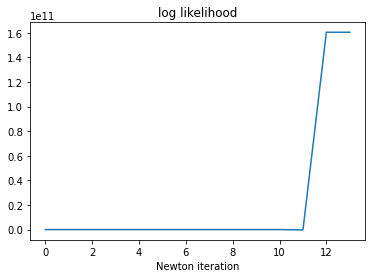

In [176]:
plt.plot(m_estimates[2])
plt.title('log likelihood')
plt.xlabel('Newton iteration')
pass

In [ ]:
plt.plot(m_estimates[2])
plt.title('log likelihood')
plt.xlabel('Newton iteration')
pass

Trajectory of $\alpha$ on contour of log likelihood

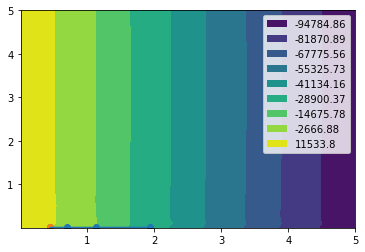

In [148]:
alpha_grid=np.linspace(0.001,5)
l=np.zeros((len(alpha_grid),len(alpha_grid)))
for i in range(len(alpha_grid)):
    for j in range(len(alpha_grid)):
        l[i,j]=utilities.loglik(np.array([alpha_grid[i],alpha_grid[j]]),gamma_list,M,k)
xx,yy=np.meshgrid(alpha_grid,alpha_grid)
cs = plt.contourf(xx,yy,l,levels=np.quantile(l,np.linspace(0,1,10)))
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in cs.collections]
plt.legend(proxy, np.round(np.quantile(l,np.linspace(0,1,10)),2))
T=70
plt.plot(np.array(list(map(lambda x: x[0],m_estimates[3])),dtype=float)[0:T],np.array(list(map(lambda x: x[1],m_estimates[3])),dtype=float)[0:T])
plt.scatter(np.array(list(map(lambda x: x[0],m_estimates[3])),dtype=float)[0:T],np.array(list(map(lambda x: x[1],m_estimates[3])),dtype=float)[0:T])
plt.scatter(x=m_estimates[3][0][0],y=m_estimates[3][0][1])
plt.show()
pass

A potential issue in Newton Raphson is it might result in negative values.

### Visualization of GD trajectory in iteration 1 of variational EM

In [131]:
random.seed(1)
e_estimates=list(map(lambda x,y: e_step(x,k,V,alpha0,beta0,y,conv_threshold=1e-5,max_iter=int(1e5)), Nd,word_dicts))
gamma_list=list(map(lambda x:x[0],e_estimates))
#print('gammalist',gamma_list)
suff_stat_list=list(map(lambda x:x[1],e_estimates))
gamma_list=list(map(lambda x:x[0],e_estimates))
#print('gammalist',gamma_list)
suff_stat_list=list(map(lambda x:x[1],e_estimates))
m_estimates_gd=m_step_gd(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-3,max_iter=int(1e4),stepsize=1e-5)

GD finished at iteration 1020


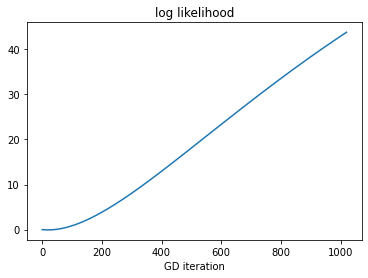

In [132]:
plt.plot(m_estimates_gd[2])
plt.title('log likelihood')
plt.xlabel('GD iteration')
pass

Choice of step size and convergence criterion is crucial here. For example, try `stepsize=1e-2`:

GD finished at iteration 47


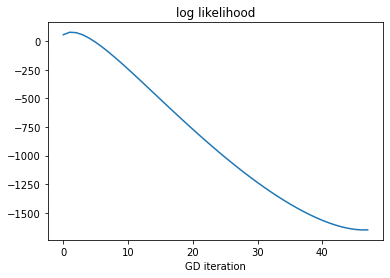

In [133]:
random.seed(1)
m_estimates_gd1=m_step_gd(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-3,max_iter=int(1e4),stepsize=1e-2)
plt.plot(m_estimates_gd1[2][0:100])
plt.title('log likelihood')
plt.xlabel('GD iteration')
pass

Trajectory of $\alpha$ on contour of log likelihood

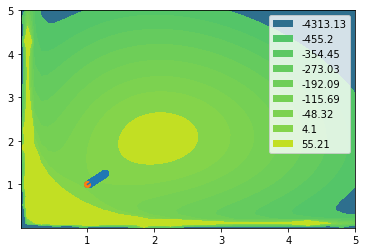

In [134]:
alpha_grid=np.linspace(0.001,5)
l=np.zeros((len(alpha_grid),len(alpha_grid)))
for i in range(len(alpha_grid)):
    for j in range(len(alpha_grid)):
        l[i,j]=utilities.loglik(np.array([alpha_grid[i],alpha_grid[j]]),gamma_list,M,k)
xx,yy=np.meshgrid(alpha_grid,alpha_grid)
cs = plt.contourf(xx,yy,l,levels=np.quantile(l,np.linspace(0,1,10)))
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in cs.collections]
plt.legend(proxy, np.round(np.quantile(l,np.linspace(0,1,10)),2))
T=500
plt.plot(np.array(list(map(lambda x: x[0],m_estimates_gd[3])),dtype=float)[0:T],np.array(list(map(lambda x: x[1],m_estimates_gd[3])),dtype=float)[0:T])
plt.scatter(np.array(list(map(lambda x: x[0],m_estimates_gd[3])),dtype=float)[0:T],np.array(list(map(lambda x: x[1],m_estimates_gd[3])),dtype=float)[0:T])
plt.scatter(x=m_estimates_gd[3][0][0],y=m_estimates_gd[3][0][1])
plt.show()
pass

In [11]:
def m_step_exp(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=1e-5,max_iter=int(1e6)):
    """
    M-step in variational EM, maximizing the lower bound on log-likelihood w.r.t. alpha and beta. (Section 5.3)
    Arguments:
    M: number of documents in the corpus
    k: number of topics
    V: length of vocab
    suff_stat_list: M-list of sufficient statistics (k * V matrices), one for each doc
    gamma_list: M-list of gamma's (k-vectors), one for each doc
    alpha0: initialization of alpha in Newton-Raphson
    conv_threshold: convergence threshold in Newton-Raphson
    max_iter: maximum number of iterations in Newton-Raphson
    Output:
    A 2-tuple. 
    First element: beta (k*V matrix)
    Second element: alpha (k*1)
    """
    alphalist=[alpha0]
    ll=[]
    ll0=conv_threshold
    conv=False
    # update beta
    beta=reduce(lambda x,y: x+y, suff_stat_list)
    beta=beta/np.sum(beta,axis=1).reshape((-1,1))
    # update alpha (Newton-Raphson)
    alpha0=alpha0.reshape((k,1))
    psi_sum_gamma=np.array(list(map(lambda x: psi(np.sum(x)),gamma_list))).reshape((M,1)) # M*1 
    psi_gamma=psi(np.array(gamma_list)) # M*k matrix
    #print('gamma',psi_sum_gamma,psi_gamma)
    for it in range(max_iter):
        a0=np.log(alpha0)
        psi_sum_alpha=psi(np.sum(alpha0))
        poly_sum_alpha=polygamma(1,np.sum(alpha0))
        #print('psi_sum_alpha',psi_sum_alpha)
        g=M*(psi_sum_alpha-psi(alpha0)).reshape((k,1))+np.sum(psi_gamma-psi_sum_gamma,axis=0).reshape((k,1))*alpha0.reshape((k,1)) # k*1
        #print(g)
        #print(np.diag(g.reshape((k,))))
        #print(np.diag((alpha0**2*M*polygamma(1,alpha0)).reshape((k,))))
        #print(alpha0@alpha0.T*M*poly_sum_alpha)
        #print(np.diag(g.reshape((k,))+1e-10-(alpha0**2*M*polygamma(1,alpha0)).reshape((k,))))
        H=alpha0@alpha0.T*M*poly_sum_alpha+np.diag(g.reshape((k,))+1e-10-(alpha0**2*M*polygamma(1,alpha0)).reshape((k,)))
        #print(H)
        a1=a0-np.linalg.inv(H)@g
        alpha1=np.exp(a1)
        ll1=utilities.loglik(alpha1,gamma_list,M,k)
        ll.append(ll1)
        if np.abs((ll1-ll0)/ll0)<conv_threshold:
            print('newton finished at iteration',it)
            conv=True
            break
        print('alpha1:')
        print(alpha1)
        print('a1:')
        print(a1)
        #print('loglik:')
        #print(utilities.loglik(alpha1,gamma_list,M,k))
        alpha0=alpha1
        a0=np.log(alpha0)
        alphalist.append(alpha1)
        ll0=ll1
    if not conv:
        warn('Newton-Raphson has not converged. Try more iterations.')
    return (beta,alpha1,ll,alphalist)

NameError: name 'm_estimates' is not defined

In [30]:
def variational_em_all(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-5,max_iter=int(1e6),niter=int(1e6),m_func=m_step_exp):
    """
    Input:
    Nd: list of length of documents 
    alpha0: initialization of alpha
    beta0: initialization of beta. DO NOT initialize with identical rows!
    word_dicts: list of word_dict of documents, in the same order as N
    vocab: vocabulary
    M: number of documents
    k: number of topics
    """
    V=len(vocab)
    for it in range(niter):
        print(it)
        e_estimates=list(map(lambda x,y: e_step(x,k,V,alpha0,beta0,y,conv_threshold=conv_threshold,max_iter=max_iter), Nd,word_dicts))
        gamma_list=list(map(lambda x:x[0],e_estimates))
        #print('gammalist',gamma_list)
        suff_stat_list=list(map(lambda x:x[1],e_estimates))
        m_estimates=m_func(M,k,V,suff_stat_list,gamma_list,alpha0,conv_threshold=conv_threshold,max_iter=max_iter)
        alpha1=m_estimates[1]
        beta1=m_estimates[0]
        #print('alpha1=',alpha1,'beta1=',beta1)
        if np.max(np.abs(beta1-beta0))<conv_threshold:
            print('vem finished at iteration',it)
            break
        alpha0=alpha1.reshape(k)
        beta0=beta1
        #print(alpha1)
        #print(beta1)
    return (alpha0,beta0)

In [110]:
# this works
random.seed(2)
#doc1='you '*10+' fish '+' is '
#doc2='fish '*10+' you '+' is '
#docs=[doc1,doc2]*100
#docs=list(map(lambda x:x*10,docs))
d1 = "Java is a language for programming that develops a software for several platforms. A compiled code or bytecode on Java application can run on most of the operating systems including Linux, Mac operating system, and Linux. Most of the syntax of Java is derived from the C++ and C languages."
d2 = "Python supports multiple programming paradigms and comes up with a large standard library, paradigms included are object-oriented, imperative, functional and procedural."
d3 = "Go is typed statically compiled language. It was created by Robert Griesemer, Ken Thompson, and Rob Pike in 2009. This language offers garbage collection, concurrency of CSP-style, memory safety, and structural typing."
d4 = "A young girl when she first visited magical Underland, Alice Kingsleigh (Mia Wasikowska) is now a teenager with no memory of the place -- except in her dreams."
d5 = "Her life takes a turn for the unexpected when, at a garden party for her fiance and herself, she spots a certain white rabbit and tumbles down a hole after him. Reunited with her friends the Mad Hatter (Johnny Depp), the Cheshire Cat and others, Alice learns it is her destiny to end the Red Queen's (Helena Bonham Carter) reign of terror."
#d1='a '*5
#d2='b '*5
#d3=d1
#d4=d2
#d5=d3
docs=[d1,d2,d3,d4,d5]
vocab=utilities.make_vocab_from_docs(docs)

In [111]:
word_dicts=list(map(lambda x: utilities.parse_doc(x,vocab),docs))
Nd=list(map(len,docs))
k,M,V=2,len(docs),len(vocab)
alpha0=np.exp(np.random.random(k))
#alpha0=np.array([1]*k).reshape(k)
beta0=np.random.random((k,V))
#beta0=np.array([1]*V*k).reshape((k,V))
beta0=beta0/np.sum(beta0,axis=1).reshape((-1,1))
V

133

In [85]:
vem=variational_em_all(Nd,alpha0,beta0,word_dicts,vocab,M,k, conv_threshold=1e-3,max_iter=int(1e3),niter=int(100))

0
alpha1:
[[1.21450167]
 [1.09631216]]
a1:
[[0.19433385]
 [0.09195197]]
alpha1:
[[1.35299576]
 [1.25151068]]
a1:
[[0.30232122]
 [0.22435136]]
alpha1:
[[1.05333693]
 [0.96336526]]
a1:
[[ 0.05196315]
 [-0.03732265]]
alpha1:
[[3.63042883]
 [3.39667163]]
a1:
[[1.28935078]
 [1.22279602]]
alpha1:
[[1.51433911]
 [1.41022328]]
a1:
[[0.41497912]
 [0.34374804]]
alpha1:
[[0.9698217 ]
 [0.89043221]]
a1:
[[-0.03064304]
 [-0.11604831]]
alpha1:
[[51.96413787]
 [49.88236884]]
a1:
[[3.95055382]
 [3.90966761]]
alpha1:
[[19.24128749]
 [18.46289498]]
a1:
[[2.95705836]
 [2.91576304]]
alpha1:
[[7.20851797]
 [6.90905321]]
a1:
[[1.97526338]
 [1.93283261]]
alpha1:
[[2.79774792]
 [2.67278483]]
a1:
[[1.02881478]
 [0.98312094]]
alpha1:
[[1.23283769]
 [1.16574105]]
a1:
[[0.20931858]
 [0.15335698]]
alpha1:
[[1.21569394]
 [1.10285103]]
a1:
[[0.19531506]
 [0.09789868]]
alpha1:
[[1.33745301]
 [1.23322463]]
a1:
[[0.29076707]
 [0.20963239]]
alpha1:
[[1.07109735]
 [0.97943079]]
a1:
[[ 0.06868369]
 [-0.0207837 ]]
alpha1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Newton-Raphson has not converged. Try more iterations.


In [89]:
beta_post=vem[1]

In [96]:
topics=[dict(zip(list(vocab.keys()),beta_post[i,:])) for i in range(k)]

In [97]:
[sorted(topics[0].items(),key=lambda x:x[1],reverse=True)[0:10],
 sorted(topics[1].items(),key=lambda x:x[1],reverse=True)[0:10]]

[[('a', 1.0), ('b', 0.0)], [('b', 1.0), ('a', 0.0)]]

In [99]:
ttt=[sorted(topic.items(),key=lambda x:x[1],reverse=True)[0:5] for topic in topics]

In [102]:
ttt[0][1]

('b', 0.0)

In [109]:
[i[0][1] for i in word_dicts]

[5, 5, 5, 5, 5]

In [108]:
word_dicts

[[(0, 5)], [(1, 5)], [(0, 5)], [(1, 5)], [(0, 5)]]